# Addestramento modello

In questo caso, viene considerato il classificatore RandomForest.

> Import necessari

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

> Montaggio di Drive

In [109]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Divisione del dataset in train e test

In [ ]:
# Lettura del dataset (drive)
csv_path = '/content/drive/MyDrive/Progetto_FDSML_github/FakeAccountDetection/datasets/cleaned_dataset.csv'

In [114]:
# Lettura del dataset (local)
csv_path = './datasets/cleaned_dataset.csv'

In [115]:
df = pd.read_csv(csv_path)

In [116]:
# Divisione in train e test set
X = df.copy()
y = X.pop('fake')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

### 1.1 Addestramento senza iperparametri

In [117]:
# Istanziazione e addestramento del classificatore
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9985067197610752
Precision: 0.9990049751243781
Recall: 0.9980119284294234
F1-Score: 0.9985082048731975


## 2. Grid Search Cross Validation

In [118]:
# Griglia dei parametri
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20]
}

In [119]:
# Istanziazione del classificatore
rfc = RandomForestClassifier()

In [120]:
%%time
# Stampiamo i migliori parametri
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True, error_score='raise')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
CPU times: total: 859 ms
Wall time: 19.6 s


In [121]:
# Vediamo come si comporta nelle diverse combinaizoni di parametri
cvres = grid_search.cv_results_

for i, (accuracy, params) in enumerate(zip(cvres["mean_test_score"], cvres["params"])):
    print(f"Iterazione {i}: Accuracy {accuracy}, Parametri {params}")

Iterazione 0: Accuracy 0.997634492543509, Parametri {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Iterazione 1: Accuracy 0.9975101144340563, Parametri {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Iterazione 2: Accuracy 0.9975101144340563, Parametri {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Iterazione 3: Accuracy 0.9973855814328111, Parametri {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Iterazione 4: Accuracy 0.9977591804365471, Parametri {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Iterazione 5: Accuracy 0.9976346474353017, Parametri {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Iterazione 6: Accuracy 0.9975101144340563, Parametri {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
Iterazione 7: Accuracy 0.9981324696566978, Parametri {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}


## 3. Feature Importances

In [122]:
# Vediamo l'importanza delle features in fase di addestramento
df_feature_importances = pd.DataFrame({
    'featureImportance': grid_search.best_estimator_.feature_importances_,
    'attribute': X_train.columns
})

df_feature_importances_sorted = df_feature_importances.sort_values(by='featureImportance', ascending=False)
df_feature_importances_sorted.reset_index(inplace=True, drop=True)
df_feature_importances_sorted

,featureImportance,attribute
0,0.298514,followerCount
1,0.152305,followingCount
2,0.137264,videoCount
3,0.121592,heartCount
4,0.092234,nicknameLength
5,0.066937,diggCount
6,0.034467,signatureLength
7,0.028134,openFavorite
8,0.024343,uniqueIdLength
9,0.023796,nicknameNumSpecialCharacters


## 4. Metriche del modello migliore

> Vengono misurate le metriche a seguito dell'Hyperparameter Tuning.

In [123]:
rfc_final = grid_search.best_estimator_
y_pred = rfc_final.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9980089596814335
Precision: 0.9980119284294234
Recall: 0.9980119284294234
F1-Score: 0.9980119284294234


### 4.1 Learning Curve

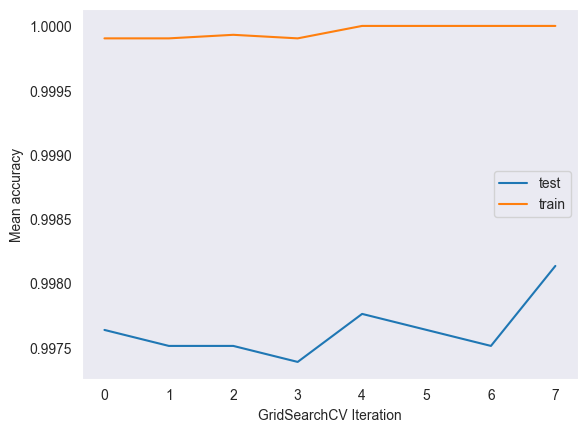

In [124]:
test_scores = cvres['mean_test_score']
train_scores = cvres['mean_train_score']

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.xlabel('GridSearchCV Iteration')
plt.ylabel('Mean accuracy')
plt.legend(loc='best')
plt.grid(visible=False)
plt.show()

### 4.2 Matrice di confusione

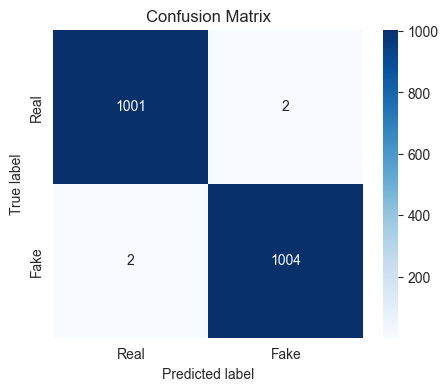

<Figure size 640x480 with 0 Axes>

In [125]:
cm = confusion_matrix(y_test, y_pred)
class_names = ['Real', 'Fake']

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Salva il grafico come file PDF
plt.savefig('confusion_matrix_NameOfClassifier.pdf', format='pdf')

### 4.3 Roc Curve

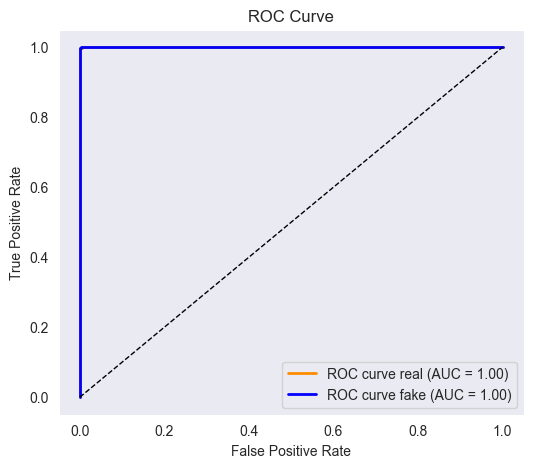

In [126]:
y_proba = rfc_final.predict_proba(X_test)

# Calcolo della curva ROC per la classe 'real' (label 0)
fpr_real, tpr_real, _ = roc_curve(y_test, y_proba[:, 0], pos_label=0)
roc_auc_real = auc(fpr_real, tpr_real)

# Calcolo della curva ROC per la classe 'fake' (lebel 1)
fpr_fake, tpr_fake, _ = roc_curve(y_test, y_proba[:, 1], pos_label=1)
roc_auc_fake = auc(fpr_fake, tpr_fake)

# Tracciamento delle curve ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_real, tpr_real, color='darkorange', lw=2, label=f'ROC curve real (AUC = {roc_auc_real:.2f})')
plt.plot(fpr_fake, tpr_fake, color='blue', lw=2, label=f'ROC curve fake (AUC = {roc_auc_fake:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend()
plt.title('ROC Curve')
plt.show()